In [35]:
import sys
import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as plot
import seaborn as sns
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils
from tools.utils import play

sys.path.append('/Users/46h/Research/code/accphys/pyorbit/measurement/')
from data_analysis import to_vec, to_mat, reconstruct

In [36]:
plot.rc['figure.facecolor'] = 'white'
# plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'
plot.rc['axes.grid'] = False

save_figures = True

In [37]:
def save(figname):
    if save_figures:
        plt.savefig(''.join(['_output/figures/', figname, '.png']), facecolor='white', dpi=250)

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_input/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different optics settings between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, so if all these are used the coefficient array will be $15N \times 10$. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

## RTBT lattice functions 

In [38]:
twiss = pd.read_csv('_output/data/twiss.dat')
ws_positions = np.loadtxt('_output/data/ws_positions.dat')

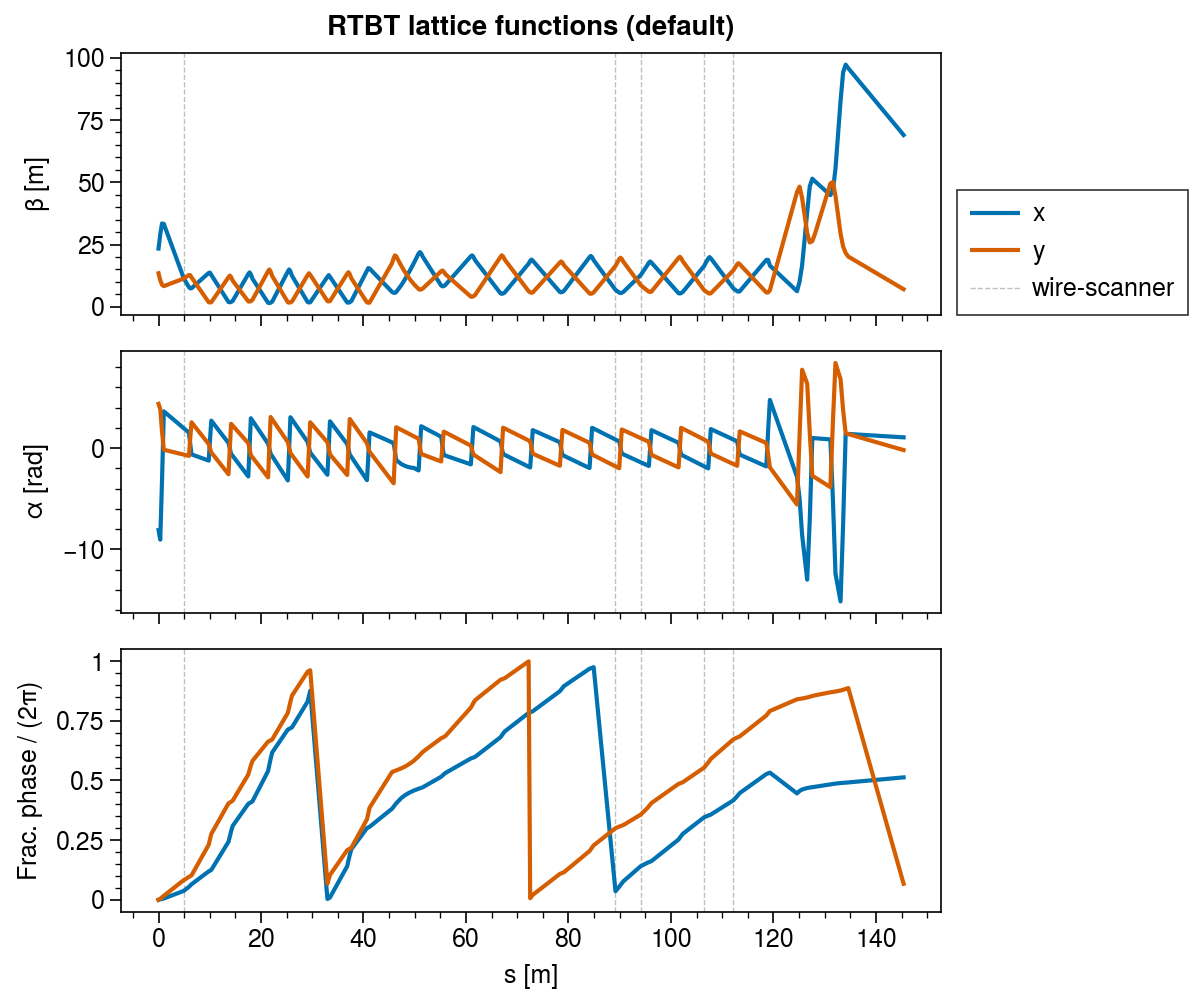

In [39]:
fig, axes = plot.subplots(nrows=3, figsize=(6, 5), spany=False)
ax1, ax2, ax3 = axes
twiss[['s','bx','by']].plot('s', ax=ax1, legend=False)
twiss[['s','ax','ay']].plot('s', ax=ax2, legend=False)
twiss[['s','nux','nuy']].plot('s', ax=ax3, legend=False)
axes.format(xlabel='s [m]', toplabels='RTBT lattice functions (default)', grid=False)
for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
    ax.format(ylabel=ylabel);
    for ws_position in ws_positions:
        ax.axvline(ws_position, color='grey', ls='--', lw=0.5, alpha=0.5, zorder=0)
ax1.legend(labels=['x', 'y', 'wire-scanner'], ncols=1, loc=(1.02, 0));
save('twiss_default')

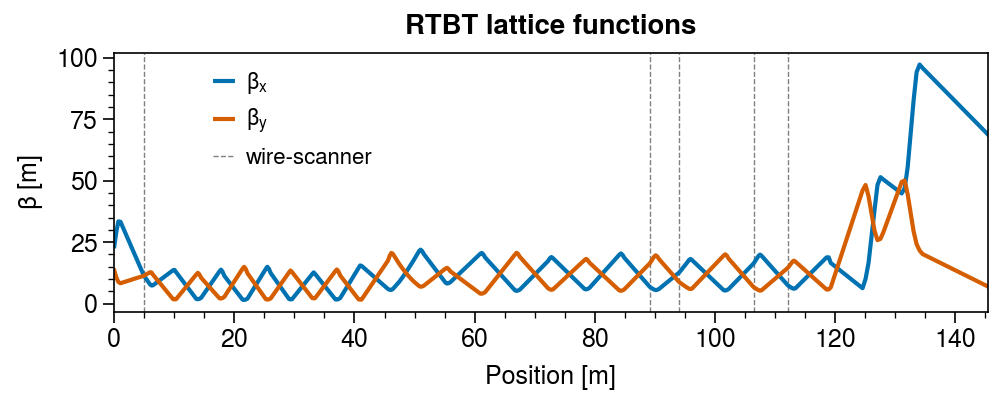

In [40]:
fig, ax = plot.subplots(figsize=(5, 2))
twiss[['s','bx','by']].plot('s', ax=ax, legend=False)
ax.format(xlabel='Position [m]', ylabel=r'$\beta$ [m]', toplabels='RTBT lattice functions')
for ws_position in ws_positions:
    ax.axvline(ws_position, color='grey', ls='--', lw=0.5, zorder=0)
ax.format(xlim=(0, twiss['s'].max()))
ax.legend(labels=[r'$\beta_x$', r'$\beta_y$', 'wire-scanner'], ncols=1, fontsize=8, handlelength=1.0, frameon=False, loc=(0.1, 0.51));
plt.savefig('_output/figures/beta.png', facecolor='white', dpi=250)

## Phase scan

In [41]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
active_ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']

In [42]:
def load(filename, ws_name):
    path = '_output/data/{}/{}'.format(ws_name, filename)
    return np.load(path)

phases_dict = {ws: load('phases.npy', ws) for ws in ws_names}
moments_dict = {ws: 1e6 * load('moments.npy', ws) for ws in ws_names}
transfer_mats_dict = {ws: load('transfer_mats.npy', ws) for ws in ws_names}
env_params_dict = {ws: 1e3 * load('env_params.npy', ws) for ws in ws_names}

phases = np.vstack([phases_dict[ws] for ws in active_ws_names])
moments = np.vstack([moments_dict[ws] for ws in active_ws_names]) # measured 
transfer_mats = np.vstack([transfer_mats_dict[ws] for ws in active_ws_names])
env_params = np.vstack([env_params_dict[ws] for ws in active_ws_names])
    
Sigma0 = 1e6 * np.loadtxt('_output/data/Sigma0.dat')
X0 = 1e3 * np.loadtxt('_output/data/X0.dat')

Observe the beam at the wire-scanners. Any greyed-out wire-scanners are not used in the reconstruction.

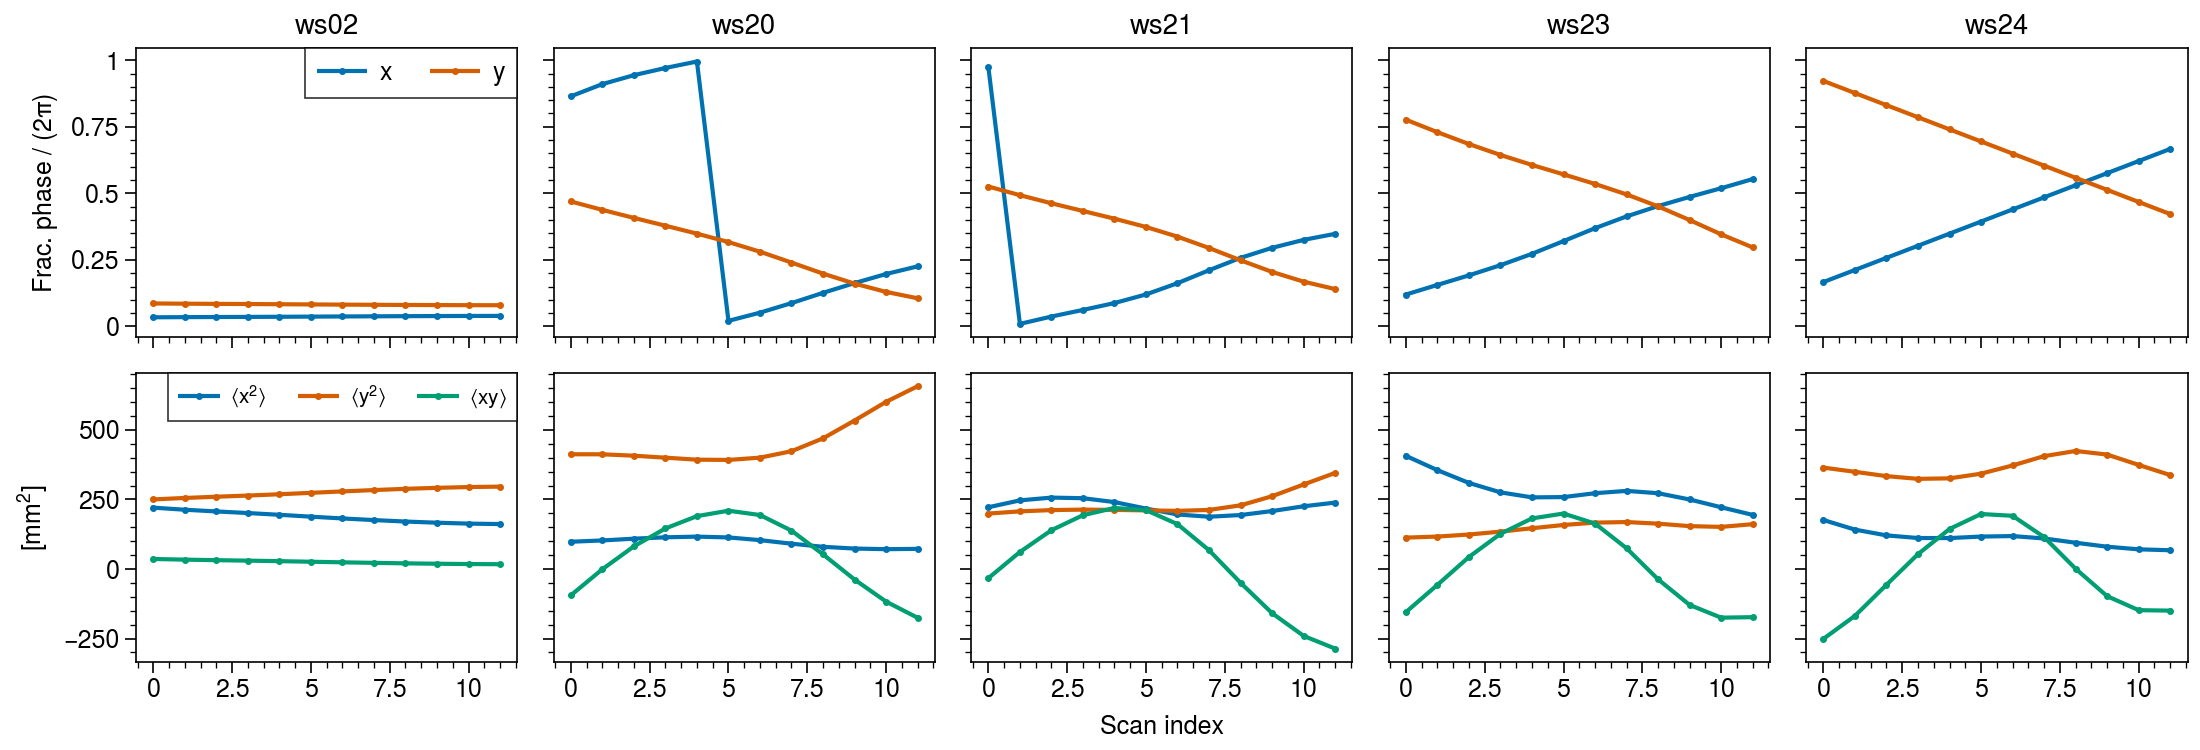

In [43]:
fig, axes = plot.subplots(nrows=2, ncols=5, figsize=(11, 3.75), spany=False)
for ax, ws_name in zip(axes[0, :], ws_names):
    ax.plot(phases_dict[ws_name] % 1, marker='.', ms=3);
    ax.set_title(ws_name)
for ax, ws_name in zip(axes[1, :], ws_names):
    ax.plot(moments_dict[ws_name][:, 0], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 1], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 2], marker='.', ms=3)
axes[0, 0].legend(labels=['x', 'y'], ncols=3);
axes[1, 0].format(ylabel='[mm$^2$]')
axes[1, 0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small');

axes[0, 0].format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index')
save('ws_phase_adv')

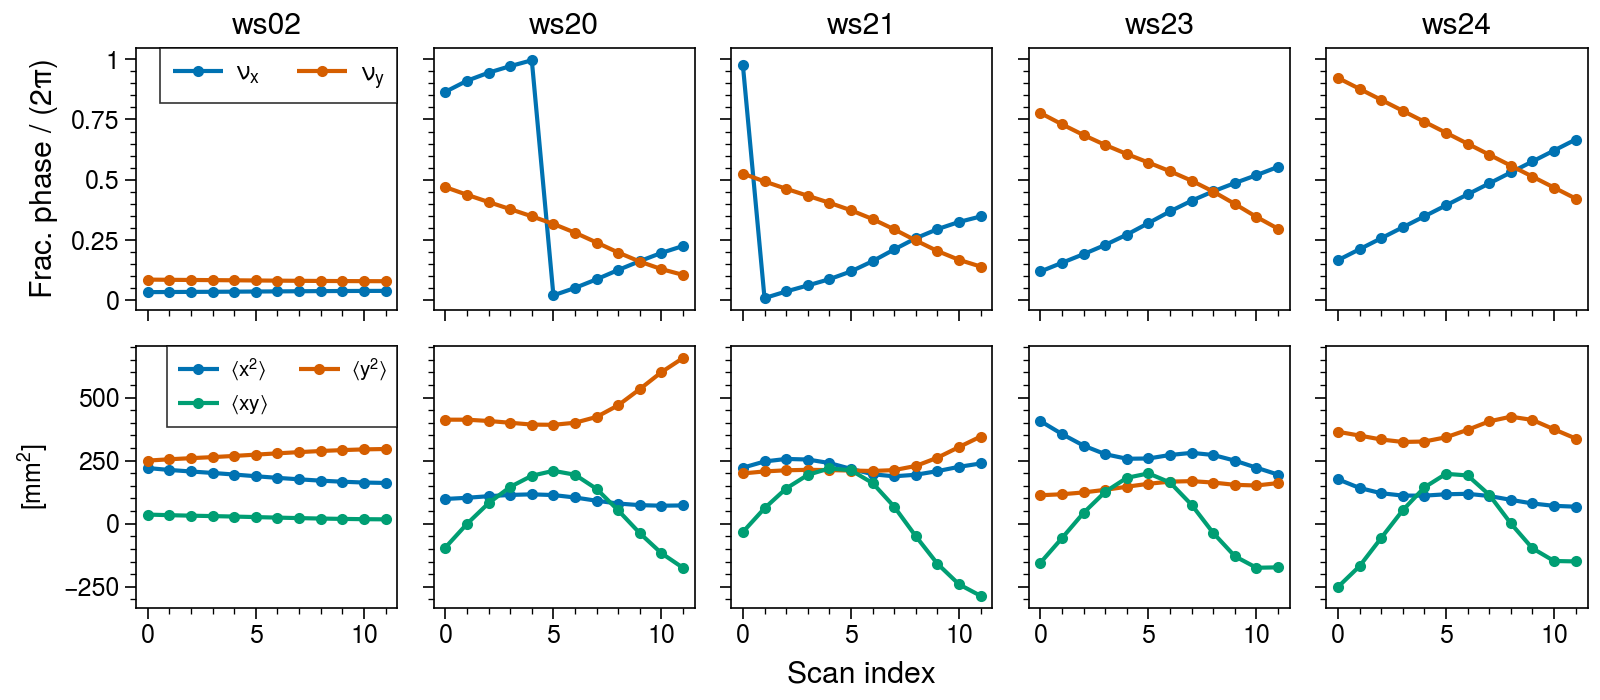

In [44]:
ms = None
m = '.'

fig, axes = plot.subplots(nrows=2, ncols=5, figsize=(8, 3.5), spany=False)
for ax, ws_name in zip(axes[0, :], ws_names):
    ax.plot(phases_dict[ws_name] % 1, marker=m, ms=ms);
    ax.set_title(ws_name, fontsize='large')
for ax, ws_name in zip(axes[1, :], ws_names):
    ax.plot(moments_dict[ws_name][:, 0], marker=m, ms=ms)
    ax.plot(moments_dict[ws_name][:, 1], marker=m, ms=ms)
    ax.plot(moments_dict[ws_name][:, 2], marker=m, ms=ms)
axes[0, 0].legend(labels=[r'$\nu_x$', r'$\nu_y$'], ncols=3);
axes[1, 0].format(ylabel='[mm$^2$]')
axes[1, 0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small', ncols=2);

axes[0, 0].format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'})
plt.savefig('_output/figures/ws_phase_adv.png', facecolor='white', dpi=350)

To do: 
* Add column below showing phase vs scan index.
* Add diagonal line at angle of diagonal wire.

In [11]:
dims = ('x', 'y')

In [12]:
str_to_int = {'x':0, 'xp':1, 'y':2, 'yp':3}
i, j = [str_to_int[dim] for dim in dims]

ell_coords_list = [ea.get_ellipse_coords(env_params_dict[ws]) for ws in ws_names]

pad = 0.25
limits_list = np.array([(1 + pad) * myplt.get_u_up_max_global(coords) for coords in ell_coords_list])
umax, upmax = np.max(limits_list, axis=0)
limits = 2 * [(-umax, umax), (-upmax, upmax)]
labels = ['x [mm]', "x' [mrad]", 'y [mm]', "y' [mrad]"]

fig, ax_list = plt.subplots(ncols=6, figsize=(13, 1.75), sharex=True, sharey=True)
axes, text_ax = ax_list[:-1], ax_list[-1]
text_ax.grid(False)
myplt.despine([text_ax], 'all')
myplt.despine(axes)
axes[0].set_xlim(limits[i])
axes[0].set_ylim(limits[j])
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_xlabel(labels[i])
axes[0].set_ylabel(labels[j])
for ax, ws_name in zip(axes, ws_names):
    ax.set_title(ws_name, color='grey' if ws_name not in active_ws_names else 'k')
    ax.grid(False)
    ax.axvline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
    ax.axhline(0, lw=0.2, c='k', alpha=0.2, zorder=99)
plt.close()

def update(t):
    for ax, coords in zip(axes, ell_coords_list):
        for patch in ax.patches:
            patch.remove()
        ax.fill(coords[t, :, i], coords[t, :, j], fc='lightsteelblue', ec='k', zorder=10)
    for ws, ax in zip(ws_names, axes):
        nux, nuy = phases_dict[ws][t]
        for text in ax.texts:
            text.set_visible(False)
        ax.annotate(r'$\nu_x = {:.2f}$'.format(nux), xy=(0.75, 0.85), xycoords='axes fraction', zorder=10)
        ax.annotate(r'$\nu_y = {:.2f}$'.format(nuy), xy=(0.75, 0.75), xycoords='axes fraction', zorder=10)
    for text in text_ax.texts:
        text.set_visible(False)
    text_ax.annotate('Scan index = {}'.format(t), xy=(0.25, 0.5), xycoords='axes fraction', horizontalalignment='center')

nframes = ell_coords_list[0].shape[0]
fps = 1
anim = animation.FuncAnimation(fig, update, frames=nframes, interval=1000/fps)
if save_figures:
     anim.save('_output/figures/ws_envelope.mp4', dpi=300)
anim

In [13]:
# for ws in ws_names:
#     print(ws)
#     play(myanim.corner_env(env_params_dict[ws], figsize=(4, 4), text_fmt='Scan index = {}'))

In [14]:
# myplt.corner(X0, moments=True, text='Initial bunch');
# save('initial_dist')

## Reconstruction

In [53]:
def compare_ellipses(Sigma, Sigma0):
    axes = myplt.rms_ellipses(Sigma0, color='lightsteelblue', fill=True, lw=0);
    axes = myplt.rms_ellipses(Sigma, axes=axes, color='red8', lw=1)
    axes[1, 1].legend(labels=['True', 'Reconstructed'], loc=(0, 1.1))
    return axes

The unconstrained solution is optimal.
Final cost 9.3110e-01, first-order optimality 9.69e-08

Sigma =
⎡376.83   130.23   -59.311    44.962 ⎤
⎢                                    ⎥
⎢130.23   45.701   -35.352    20.18  ⎥
⎢                                    ⎥
⎢-59.311  -35.352  327.049   -106.337⎥
⎢                                    ⎥
⎣44.962    20.18   -106.337   36.375 ⎦

Sigma0 =
⎡376.735  130.198  -59.278    44.94  ⎤
⎢                                    ⎥
⎢130.198   45.69    -35.33    20.169 ⎥
⎢                                    ⎥
⎢-59.278  -35.33   326.831   -106.267⎥
⎢                                    ⎥
⎣ 44.94   20.169   -106.267   36.352 ⎦

Sigma - Sigma0 =
⎡0.094   0.032   -0.033  0.022⎤
⎢                             ⎥
⎢0.032   0.011   -0.022  0.011⎥
⎢                             ⎥
⎢-0.033  -0.022  0.217   -0.07⎥
⎢                             ⎥
⎣0.022   0.011   -0.07   0.023⎦


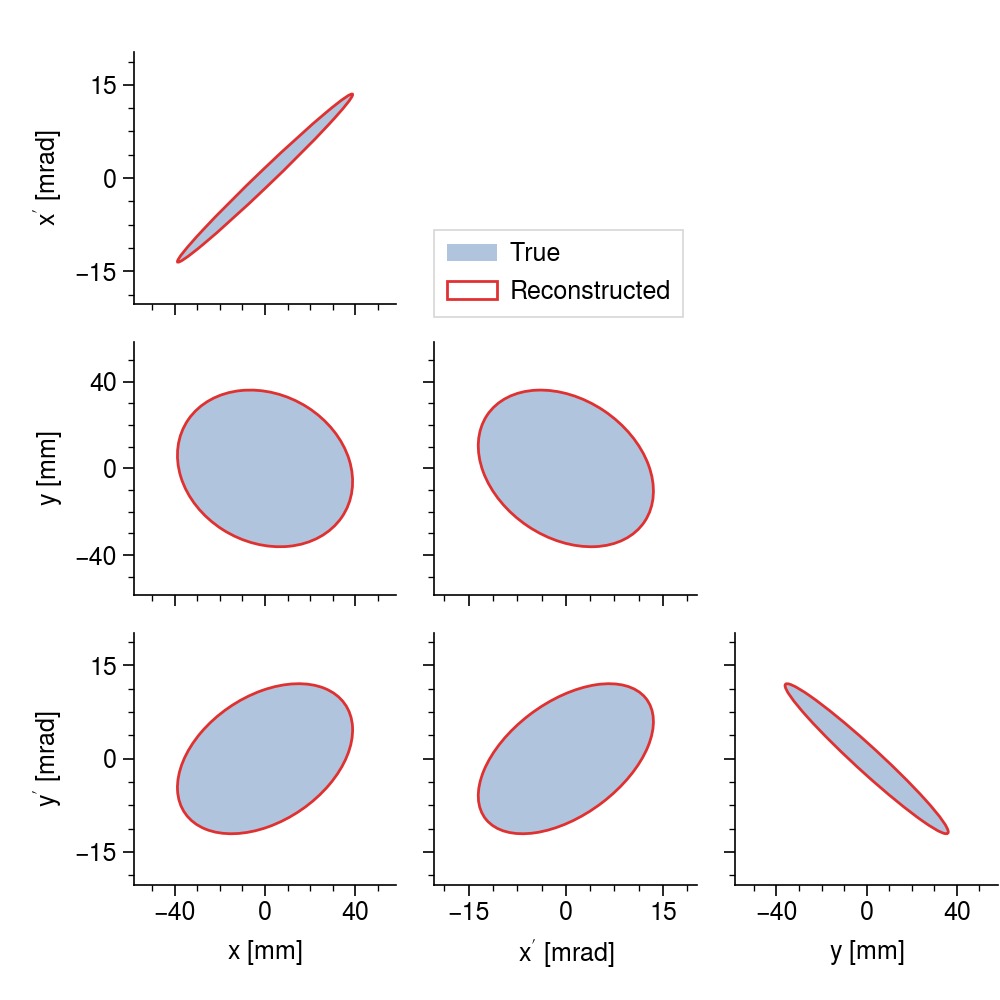

In [54]:
Sigma = reconstruct(transfer_mats, moments, verbose=2)
print()
utils.show(Sigma, 'Sigma')
print()
utils.show(Sigma0, 'Sigma0')
print()
utils.show(Sigma - Sigma0, 'Sigma - Sigma0')

compare_ellipses(Sigma, Sigma0)
save('projection_default')

## Measurement Errors 

Here we add Gaussian noise to each measured moment.

In [17]:
eps_ideal = ea.intrinsic_emittances(Sigma0)
emittances, Sigmas = {}, {}

In [18]:
def plot_emittance_comparison(varied_parameters, emittances, xlabel='', figname=None):
    emittances = np.array(emittances)
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    for i, color in enumerate(['green8', 'pink8']):
        ax.axhline(eps_ideal[i], ls='-', lw=1, color=color, alpha=0.2)
        ax.scatter(varied_parameters, emittances[:, i], c=color, s=10)
    ax.format(xlabel=xlabel, ylabel='[mm $\cdot$ mrad]', title='Reconstructed intrinsic emittance', grid=False)
    ax.legend(labels=[r'$\varepsilon_{1, true}$', r'$\varepsilon_{2, true}$', 
                      r'$\varepsilon_{1, meas}$', r'$\varepsilon_{2, meas}$'], ncols=1, loc=(1.02, 0))
    if figname:
        save(figname)
    plt.show()
    
def plot_moment_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    Sigmas = np.array(Sigmas)
    colors = ['blue8', 'orange6', 'green8']
    for color, i, j in zip(colors, [0, 2, 0], [0, 2, 2]):
        ax.axhline(Sigma0[i, j], color=color, alpha=0.2)
        ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c=color);
    ax.format(xlabel=xlabel, ylabel='[mm$^2$]', title='Reconstructed moments', grid=False)
    ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1, loc=(1.02, 0));
    if figname:
        save(figname)
    plt.show()
    
def plot_all_moments_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, axes = plot.subplots(nrows=4, ncols=4, figsize=(10, 6), sharey=False, spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel=xlabel, suptitle='Reconstructed moments', grid=False)
    Sigmas = np.array(Sigmas)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            ax.axhline(Sigma0[i, j], color='red8', alpha=0.2)
            ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c='k')
            ax.format(title=utils.get_moments_label(i, j))
    myplt.set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    myplt.set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    myplt.set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    myplt.set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    if figname:
        save(figname)
    plt.show()

In [19]:
def blur(array, stdev=1.0, mean=0.0):
    return array + np.random.normal(loc=mean, scale=stdev, size=array.shape)

guess = to_vec(Sigma0)
stdev_min, stdev_max = (0.0, 16.0) # [mm^2]
nsteps = 25
trials_per_step = 3

stdevs = np.repeat(np.linspace(stdev_min, stdev_max, nsteps), trials_per_step)
emittances['meas_err'], Sigmas['meas_err'] = [], []
for stdev in tqdm(stdevs):
    Sigma = reconstruct(transfer_mats, blur(moments, stdev))
    emittances['meas_err'].append(ea.intrinsic_emittances(Sigma))
    Sigmas['meas_err'].append(Sigma)

100%|██████████| 75/75 [00:00<00:00, 497.79it/s]


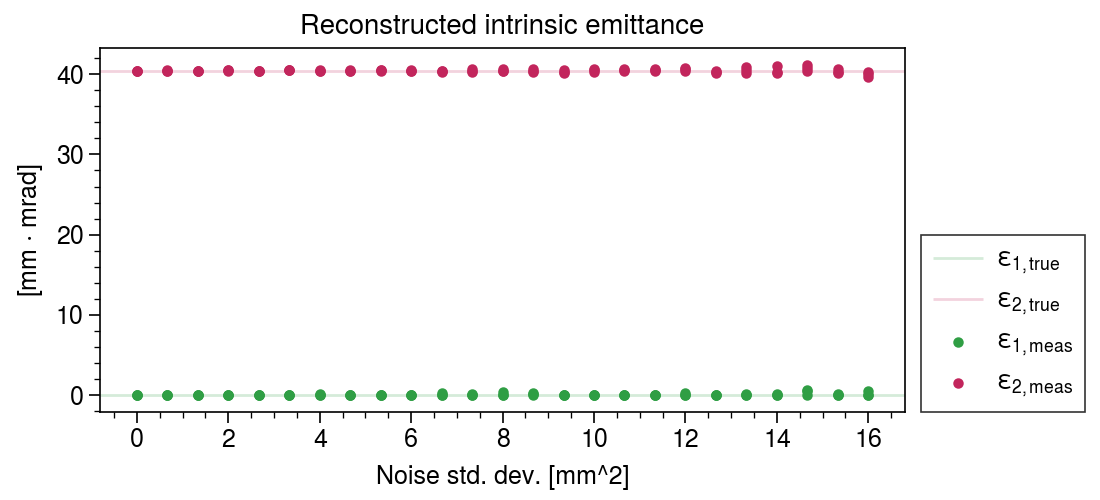

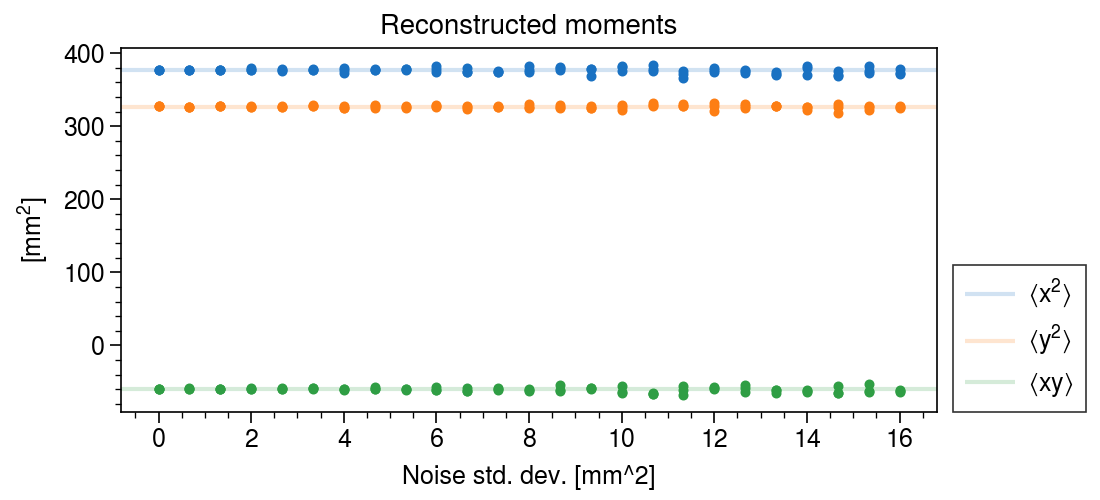

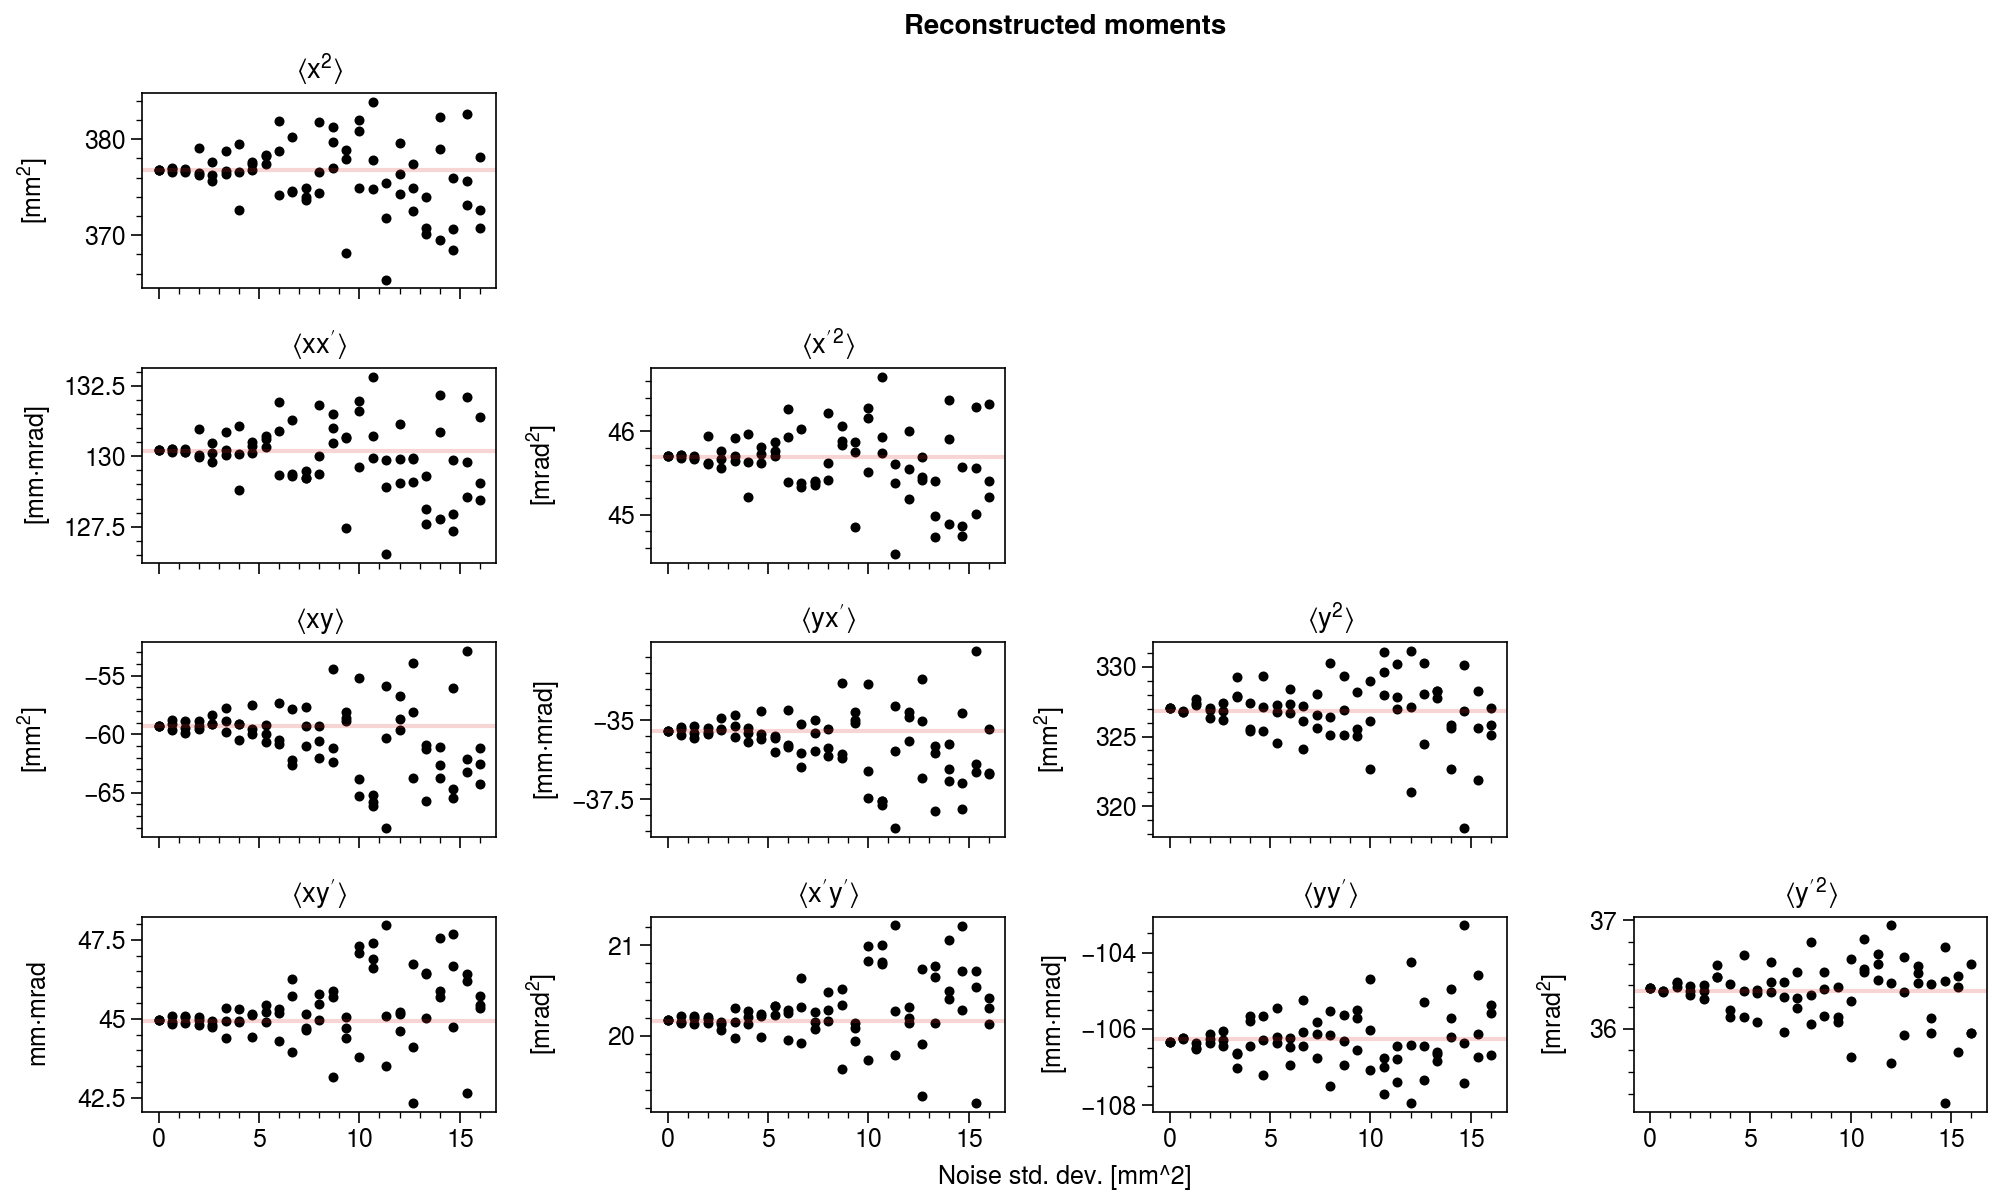

In [20]:
xlabel = 'Noise std. dev. [mm^2]'
plot_emittance_comparison(stdevs, emittances['meas_err'], xlabel, figname='emittance_meas_err')
plot_moment_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_meas_err')
plot_all_moments_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_all_meas_err')

## Visualization using lines

In [21]:
ax0, ay0, bx0, by0 = (-8.082, 4.380, 23.373, 13.455)
ex, ey = ea.apparent_emittances(Sigma0)

def V_2D(alpha, beta):
    return np.array([[beta, 0.0], [-alpha, 1.0]]) / np.sqrt(beta)

V = np.zeros((4, 4))
V[:2, :2] = V_2D(ax0, bx0)
V[2:, 2:] = V_2D(ay0, by0)
Vinv = np.linalg.inv(V)

def normalize(vec):
    return np.matmul(Vinv, vec)

scale = 2
xmax = scale * np.sqrt(ex)
ymax = scale * np.sqrt(ey)

In [55]:
def get_line_points(M, sig_xx, sig_yy, dim, upmin=-10, upmax=10):
    xrms, yrms = np.sqrt(sig_xx), np.sqrt(sig_yy)
    hpts, vpts = [], []
    for up in [upmin, upmax]:
        if dim == 'x':
            vec1 = [xrms, up, 0, 0]
            i, j = 0, 1
        elif dim == 'y':
            vec1 = [0, 0, yrms, up]
            i, j = 2, 3
        vec0 = np.matmul(np.linalg.inv(M), vec1)
        vec0 = normalize(vec0)
        hpts.append(vec0[i])
        vpts.append(vec0[j])
    return hpts, vpts

def plot_lines(ax, transfer_mats, moments, dim='x', **kws):  
    for M, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats, moments):
        hpts, vpts = get_line_points(M, sig_xx, sig_yy, dim)
        ax.plot(hpts, vpts, **kws)
    return ax

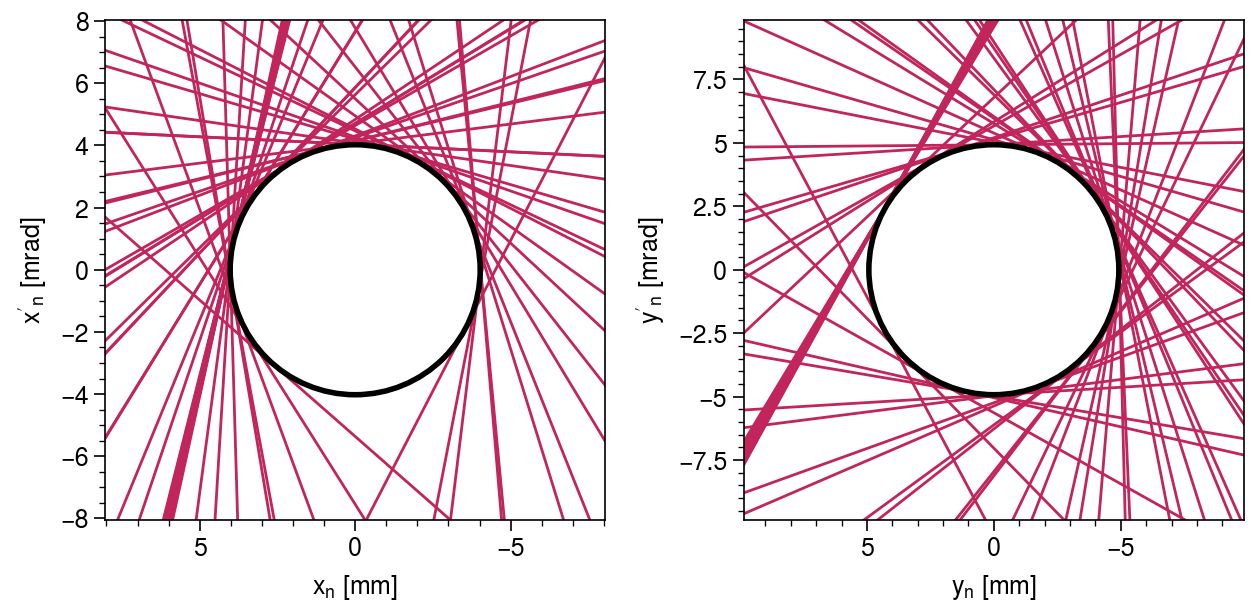

In [57]:
active_ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
# active_ws_names = ['ws24']
nmeas = -1
moments = np.vstack([moments_dict[ws][:nmeas] for ws in active_ws_names]) 
transfer_mats = np.vstack([transfer_mats_dict[ws][:nmeas] for ws in active_ws_names])

moments += 0 * np.random.normal(size=moments.shape)

fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
axes.format(aspect=1)
axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$ [mm]", ylabel=r"$x'_n$ [mrad]")
axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
myplt.ellipse(axes[0], np.sqrt(ex), np.sqrt(ex), lw=2, zorder=999)
myplt.ellipse(axes[1], np.sqrt(ey), np.sqrt(ey), lw=2, zorder=999)


# axes.format(cycle='plum')
nscans = len(transfer_mats)
imid = nscans // 2
imin, imax = 0, -1
kws = dict(color='pink8', lw=1)
plot_lines(axes[0], transfer_mats[imin:imax], moments[imin:imax], 'x', **kws);
plot_lines(axes[1], transfer_mats[imin:imax], moments[imin:imax], 'y', **kws);
save('lines')

In [24]:
# fig, axes = plot.subplots(ncols=2, sharex=False, sharey=False)
# axes.format(aspect=1)
# axes[0].format(xlim=(-xmax, xmax), ylim=(-xmax, xmax), xlabel=r"$x_n$ [mm]", ylabel=r"$x'_n$ [mrad]")
# axes[1].format(xlim=(-ymax, ymax), ylim=(-ymax, ymax), xlabel=r"$y_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
# myplt.ellipse(axes[0], np.sqrt(ex), np.sqrt(ex), lw=2, zorder=999)
# myplt.ellipse(axes[1], np.sqrt(ey), np.sqrt(ey), lw=2, zorder=999)
# plt.close()

# def update(i):
#     plot_lines(axes[0], transfer_mats[:i+1], moments[:i+1], 'x')
#     plot_lines(axes[1], transfer_mats[:i+1], moments[:i+1], 'y')
    
# animation.FuncAnimation(fig, update, frames=len(transfer_mats))

I thought maybe we could do something similar for the other projections, but it doesn't seem to work since the transfer matrix is completely uncoupled. For example, choosing a different $y'$ at the measurement location has no effect on the $x$ at the reconstruction location, so you just get a series of vertical lines in the $x$-$y'$ plane.

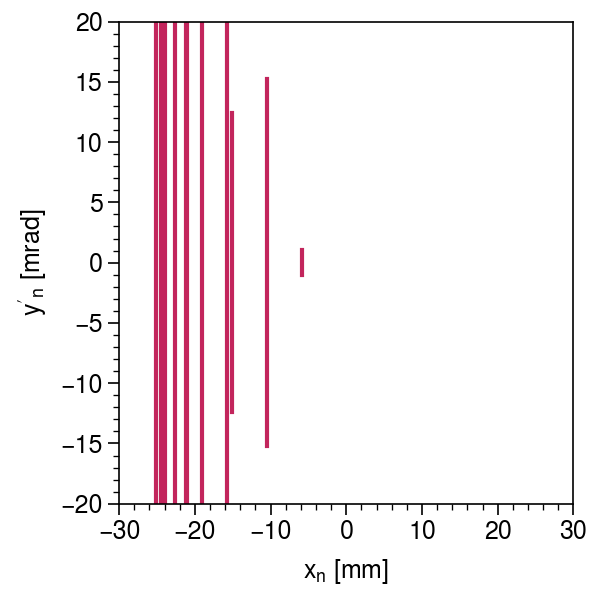

In [25]:
def get_line_points_xyp(M, sig_xx, sig_yy, sig_xy, ypmin=-10, ypmax=10):
    xrms, yrms = np.sqrt(sig_xx), np.sqrt(sig_yy)
    r = sig_xy / (xrms * yrms)
    hpts, vpts = [], []
    for yp in [ypmin, ypmax]:
        vec1 = [xrms, 0, 0, yp]
        vec0 = np.matmul(np.linalg.inv(M), vec1)
        hpts.append(vec0[0])
        vpts.append(vec0[3])
    return hpts, vpts

def plot_lines_xyp(ax, transfer_mats, moments):  
    for M, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats, moments):
        hpts, vpts = get_line_points_xyp(M, sig_xx, sig_yy, sig_xy)
        ax.plot(hpts, vpts, c='pink8')
    return ax
        
fig, ax = plot.subplots(figsize=(3, 3))
ax.format(xlim=(-xmax, xmax), ylim=(-ymax, ymax), xlabel=r"$x_n$ [mm]", ylabel=r"$y'_n$ [mrad]")
plot_lines_xyp(ax, transfer_mats, moments);
ax.format(xlim=(-30, 30), ylim=(-20, 20))